In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from glob import glob
import pandas as pd
import os


In [3]:
from modules.conv_blocks import *
from utils.utils import generate_model_from_config
import torch
path=  "configs/networks/custom_net_simple.yaml"
model = generate_model_from_config({'layer_config':path})
print(model)
rand_input = torch.rand(1,256,90,90)
model.eval()
output = model(rand_input)
print(output.shape)

Loading model yaml
/media/wmg-5gcat/Co-op Autonomy 2/Hakan/Introspect3D/configs/networks/custom_net_simple.yaml
Model yaml loaded
{'inp_shape': {'channels': 256, 'height': 90, 'width': 90}, 'layers': [{'type': 'BasicConvBlock', 'params': {'in_channels': 256, 'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1}}, {'type': 'BasicConvBlock', 'params': {'in_channels': 128, 'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1}}, {'type': 'BasicConvBlock', 'params': {'in_channels': 64, 'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1}}, {'type': 'Flatten', 'params': {}}, {'type': 'Linear', 'params': {'in_features': 259200, 'out_features': 2}}]}
Sequential(
  (0): BasicConvBlock(
    (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConvBlock(
    (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1),

/home/wmg-5gcat/miniforge3/envs/distest/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wmg-5gcat/miniforge3/envs/distest/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(148, 260, 3)
(148, 260)


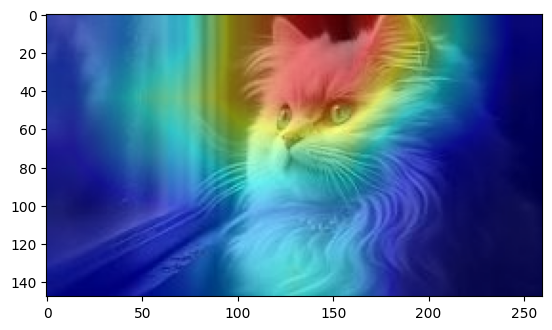

In [2]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import cv2
import torch 
import numpy as np
model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
rgb_img = r"/home/wmg-5gcat/Desktop/download.jpg"# Load an image with opencv (BGR
img = cv2.imread(rgb_img)
#Convert img to tensor
# img = cv2.resize(img, (224, 224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = img.astype(np.float32) / 255
img_t = np.transpose(img, (2, 0, 1))
print(img.shape)
# img = np.expand_dims(img, axis=0)
img_t = img_t.astype(np.float32)
input_tensor = torch.tensor(img_t)
input_tensor = input_tensor.unsqueeze(0)
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(281)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
print(grayscale_cam.shape)
img = img.astype(np.float32)/255
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
model_outputs = cam.outputs
#Plot visualization
from matplotlib import pyplot as plt
plt.imshow(visualization)

In [3]:
path = r"/media/wmg-5gcat/Co-op Autonomy 2/Hakan/custom_dataset/nus_centerpoint_activations_filtered_objects/test/"
f_path = os.path.join(path, "features", "*.pt")
l_path = os.path.join(path, "nus_centerpoint_labels_filtered_objects.csv")
all_paths = sorted(glob(f_path))
labels= pd.read_csv(l_path)
print(len(all_paths))
print(labels.shape)

4797
(4797, 5)


In [4]:
labels['name'] = labels['name'].apply(lambda x: x.split('/')[-1])
#sort the labels
labels = labels.sort_values(by='name')

In [5]:
from datasets.nuscenes import NuScenesDataset
from datasets.activation_dataset import ActivationDataset
from utils.filter import FilterType, EllipseFilter
ns = {
    'root_dir': '/media/ssd_reza/nuscenes',
    'version': 'v1.0-trainval',
    'split': 'test',
    'process': False,
    'filter_labels_only': False,
    'save_path': "/media/wmg-5gcat/Co-op Autonomy 2/Hakan/",
    'save_filename': 'nuscenes_train_fix.pkl',
    'filtering_style': 'FilterType.NONE',
    'filter_params':{
      'a': 15,
      'b': 25,
      'offset': -10,
      'axis': 1}}
# act= {
#     'config': {
#       'root_dir': "/media/wmg-5gcat/Co-op Autonomy 2/Hakan/custom_dataset/nus_centerpoint_activations_filtered_objects/test/"  ,
#       'label_file': 'nus_centerpoint_labels_filtered_objects.csv',
#       'classes': ['No Error', 'Error'],
#       'label_field': 'is_missed',
#       'layer': [0,1,2],
#       'is_multi_feature': True,
#       'is_sparse': True,
#       'extension':'.pt',
#       'name': 'nuscenes'
#       }
#       }
act= {
    'config': {
      'root_dir': "/media/wmg-5gcat/Co-op Autonomy 2/Hakan/custom_dataset/nus_centerpoint_activations_filtered_objects_lonly/test/"  ,
      'label_file': 'nus_centerpoint_labels_filtered_objects_lonly.csv',
      'classes': ['No Error', 'Error'],
      'label_field': 'is_missed',
      'layer': [0,1,2],
      'is_multi_feature': True,
      'is_sparse': True,
      'extension':'.pt',
      'name': 'nuscenes'
      }
      }
act_dataset = ActivationDataset(act['config'])
nus = NuScenesDataset(**ns)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
ROOT DIR:  /media/wmg-5gcat/Co-op Autonomy 2/Hakan/custom_dataset/nus_centerpoint_activations_filtered_objects_lonly/test/
Number of features found:  4797  in  ['/media/wmg-5gcat/Co-op Autonomy 2/Hakan/custom_dataset/nus_centerpoint_activations_filtered_objects_lonly/test/features/n008-2018-05-21-11-06-59-0400__LIDAR_TOP__1526915719047399.pt', '/media/wmg-5gcat/Co-op Autonomy 2/Hakan/custom_dataset/nus_centerpoint_activations_filtered_objects_lonly/test/features/n008-2018-05-21-11-06-59-0400__LIDAR_TOP__1526915719547865.pt', '/media/wmg-5gcat/Co-op Autonomy 2/Hakan/custom_dataset/nus_centerpoint_activations_filtered_objects_lonly/test/features/n008-2018-05-21-11-06-59-0400__LIDAR_TOP__1526915720047703.pt', '/media/wmg-5gcat/Co-op Autonomy 2/Hakan/custom_dataset/nus_centerpoint_activations_filtered_objects_lonly/test/fea

In [6]:
from mmdet3d.apis import init_model, inference_detector
# det_model_checkpoint = r'/mnt/ssd2/mmdetection3d/ckpts/centerpoint_0075voxel_second_secfpn_dcn_circlenms_4x8_cyclic_20e_nus_20220810_025930-657f67e0.pth'
det_model_checkpoint = r'/home/wmg-5gcat/Desktop/Sajjad/DistEstIntrospection/mmdetection3d/ckpts/centerpoint_0075voxel_second_secfpn_dcn_circlenms_4x8_cyclic_20e_nus_20220810_025930-657f67e0.pth'
# det_model_config= r'/mnt/ssd2/mmdetection3d/configs/centerpoint/centerpoint_voxel0075_second_secfpn_head-dcn-circlenms_8xb4-cyclic-20e_nus-3d.py'
det_model_config= r'/home/wmg-5gcat/Desktop/Sajjad/DistEstIntrospection/mmdetection3d/configs/centerpoint/centerpoint_voxel0075_second_secfpn_head-dcn-circlenms_8xb4-cyclic-20e_nus-3d.py'
det_model = init_model(det_model_config, det_model_checkpoint, device='cuda:0')

Loads checkpoint by local backend from path: /home/wmg-5gcat/Desktop/Sajjad/DistEstIntrospection/mmdetection3d/ckpts/centerpoint_0075voxel_second_secfpn_dcn_circlenms_4x8_cyclic_20e_nus_20220810_025930-657f67e0.pth
08/14 11:02:42 - mmengine - INFO - DeformConv2dPack pts_bbox_head.task_heads.0.feature_adapt_cls is upgraded to version 2.
08/14 11:02:42 - mmengine - INFO - DeformConv2dPack pts_bbox_head.task_heads.0.feature_adapt_reg is upgraded to version 2.
08/14 11:02:42 - mmengine - INFO - DeformConv2dPack pts_bbox_head.task_heads.1.feature_adapt_cls is upgraded to version 2.
08/14 11:02:42 - mmengine - INFO - DeformConv2dPack pts_bbox_head.task_heads.1.feature_adapt_reg is upgraded to version 2.
08/14 11:02:42 - mmengine - INFO - DeformConv2dPack pts_bbox_head.task_heads.2.feature_adapt_cls is upgraded to version 2.
08/14 11:02:42 - mmengine - INFO - DeformConv2dPack pts_bbox_head.task_heads.2.feature_adapt_reg is upgraded to version 2.
08/14 11:02:42 - mmengine - INFO - DeformConv2d

tensor([1])


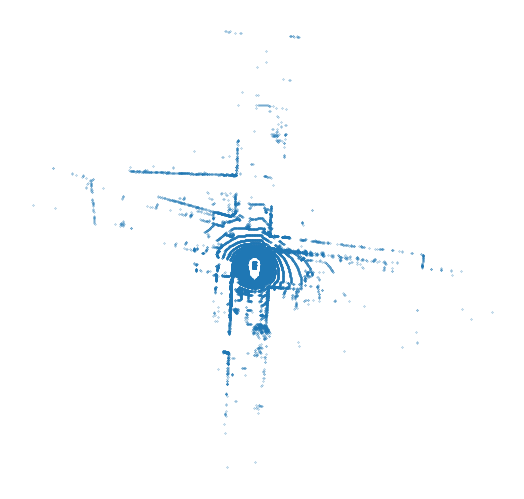

In [7]:
index = 1515

filename= act_dataset[index][-1]
sample = nus.get_with_name(filename)
cloud = sample['pointcloud'].points
plt.scatter(cloud[:,0], cloud[:,1], s=0.05)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("original_full.png", bbox_inches='tight', pad_inches=0,dpi=300)
print(act_dataset[index][1])


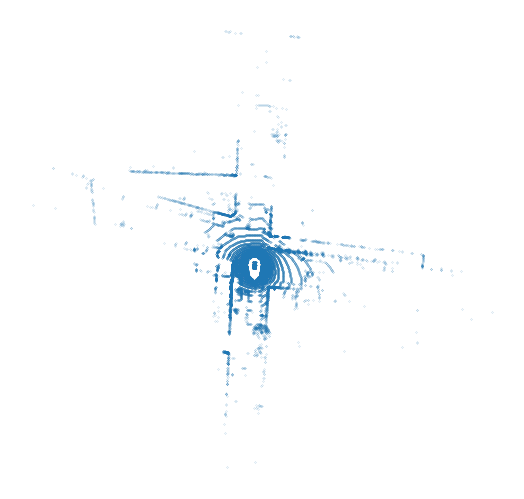

In [17]:
from utils.filter import FilteringArea
from matplotlib.patches import Ellipse

filtr = EllipseFilter( 15, 25, -10, 1)
# in_poitns = filtr.filter_pointcloud(sample['pointcloud'].points)
# out_points = filtr.filter_pointcloud(sample['pointcloud'].points, FilteringArea.OUTSIDE)

# Create a figure and axi
# Define the ellipse parameters
center_x = 0  # X-coordinate of the center
center_y = +10  # Y-coordinate of the center
width = 30     # Total width of the ellipse
height = 50    # Total height of the ellipse
angle = 0     # Angle of rotation in degrees (counterclockwise)

# Create the ellipse
# fig, ax = plt.subplots()
# plt.scatter(in_poitns[:,0], in_poitns[:,1], s=0.01,alpha=1)
# plt.scatter(out_points[:,0], out_points[:,1], s=0.01,c="#1f77b4",alpha=1)
plt.scatter(cloud[:,0], cloud[:,1], s=0.01,alpha=1)
ellipse = Ellipse((center_x, center_y), width, height, angle=angle, edgecolor='black', facecolor='none')

# Add the ellipse to the plot
# plt.gca().add_patch(ellipse)

# Set limits for the axes to better view the ellipse
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)

plt.axis('off')
plt.tight_layout(pad=0)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("fullscenewtwoe.png", bbox_inches='tight', pad_inches=0,dpi=300)


In [12]:
out = inference_detector(det_model, sample['pointcloud'].points)
scores = out[0].pred_instances_3d.scores_3d.detach().cpu().numpy()
boxes = out[0].pred_instances_3d.bboxes_3d.detach().cpu().numpy()
filt = scores > 0.5
pboxes = boxes[filt]

/home/wmg-5gcat/Desktop/Sajjad/DistEstIntrospection/mmdetection3d/mmdet3d/models/task_modules/coders/centerpoint_bbox_coders.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.post_center_range = torch.tensor(
/home/wmg-5gcat/Desktop/Sajjad/DistEstIntrospection/mmdetection3d/mmdet3d/models/task_modules/coders/centerpoint_bbox_coders.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.post_center_range = torch.tensor(


In [20]:
print(boxes.shape)
pboxes.shape

(203, 9)


(29, 9)

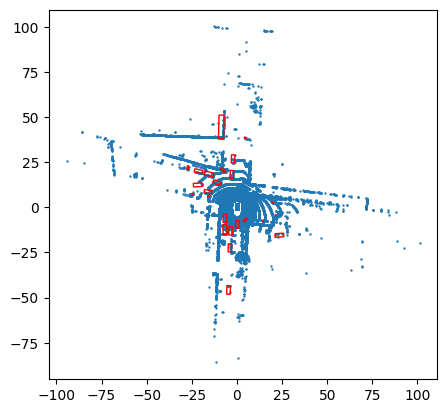

In [15]:
from matplotlib.patches import Polygon
from utils.boundingbox import BoundingBox
plt.scatter(cloud[:,0], cloud[:,1], s=0.5)
plt.gca().set_aspect('equal', adjustable='box')
# plt.gca().add_patch(ellipse)
for box in pboxes:
    pbox = BoundingBox(center = box[:3], dimensions = box[3:6], rotation = box[6])
    
    coord = pbox.corners  # 8 corners in 3D
    
    # Extract x, y, z coordinates
    x_coords = coord[:, 0]
    y_coords = coord[:, 1]
    z_coords = coord[:, 2]
    
    # Find the indices of the top 4 corners based on the highest z-values
    top_face_indices = np.argsort(z_coords)[-4:]  # Get the indices of the top 4 z-values
    
    # Extract the corresponding top face points
    top_face_points = np.array([(x_coords[i], y_coords[i]) for i in top_face_indices])
    
    # Calculate the centroid of the top face
    centroid = np.mean(top_face_points, axis=0)
    
    # Sort the points based on their angle relative to the centroid
    def angle_from_centroid(point):
        return np.arctan2(point[1] - centroid[1], point[0] - centroid[0])
    
    top_face_points_sorted = sorted(top_face_points, key=angle_from_centroid)
    
    # Create a polygon patch
    polygon = Polygon(top_face_points_sorted, closed=True, edgecolor='red', fill=None)
    
    # Add the polygon to the plot
    plt.gca().add_patch(polygon)
# plt.gca().add_patch(ellipse)
plt.axis('off')


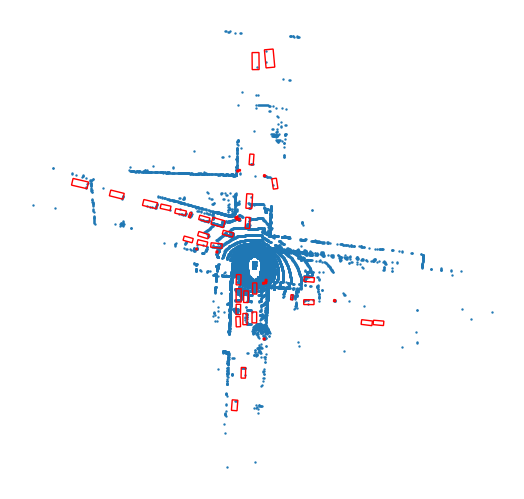

In [18]:
from matplotlib.patches import Polygon
plt.scatter(cloud[:,0], cloud[:,1], s=0.5)
boxes = sample['labels']
# boxes = filtr.filter_bounding_boxes(boxes)
for box in boxes:
    coord = box.corners  # 8 corners in 3D
    
    # Extract x, y, z coordinates
    x_coords = coord[:, 0]
    y_coords = coord[:, 1]
    z_coords = coord[:, 2]
    
    # Find the indices of the top 4 corners based on the highest z-values
    top_face_indices = np.argsort(z_coords)[-4:]  # Get the indices of the top 4 z-values
    
    # Extract the corresponding top face points
    top_face_points = np.array([(x_coords[i], y_coords[i]) for i in top_face_indices])
    
    # Calculate the centroid of the top face
    centroid = np.mean(top_face_points, axis=0)
    
    # Sort the points based on their angle relative to the centroid
    def angle_from_centroid(point):
        return np.arctan2(point[1] - centroid[1], point[0] - centroid[0])
    
    top_face_points_sorted = sorted(top_face_points, key=angle_from_centroid)
    
    # Create a polygon patch
    polygon = Polygon(top_face_points_sorted, closed=True, edgecolor='red', fill=None)
    
    # Add the polygon to the plot
    plt.gca().add_patch(polygon)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig("fullscenewoobjs.png", bbox_inches='tight', pad_inches=0,dpi=300)


In [159]:
from utils.utils import generate_model_from_config
net_conf_l = 'configs/networks/resnet18_fcn_wor.yaml'
# weight_path_l = './outputs/ckpts/nuscenes_none_resnet18_fcn_rawspring-cosmos-340__best.pth'
weight_path_l = './outputs/ckpts/nuscenes_none_resnet18_fcn_rawneat-bush-440__best.pth'
net_conf_m = 'configs/networks/resnet18_fcn2_wor.yaml'
# weight_path_m = './outputs/ckpts/nuscenes_none_resnet18_fcn2_rawstellar-feather-330__best.pth'
weight_path_m = './outputs/ckpts/nuscenes_none_resnet18_fcn2_wor_rawbalmy-dew-570__best.pth'
net_conf_e = 'configs/networks/resnet18_fcn_wor.yaml'
# weight_path_e = './outputs/ckpts/nuscenes_none_resnet18_fcn_rawsoft-dust-370__best.pth'
weight_path_e = './outputs/ckpts/nuscenes_none_resnet18_fcn_wor_rawlikely-mountain-670__best.pth'
net_conf_c = 'configs/networks/resnet18_fcn_mult_c.yaml'
# weight_path_c = './outputs/ckpts/nuscenes_none_resnet18_fcn_mult_c_efmdauntless-night-390__best.pth'
weight_path_c = './outputs/ckpts/nuscenes_none_resnet18_fcn_mult_c_efmrosy-sun-720__best.pth'
net_conf_i = 'configs/networks/resnet18_fcn_wor.yaml'
# weight_path_i = './outputs/ckpts/nuscenes_none_resnet18_fcn_multilogical-mountain-420__best.pth'
weight_path_i = './outputs/ckpts/nuscenes_none_resnet18_fcn_wor_multiupbeat-elevator-810__best.pth'

In [160]:
from modules.custom_networks import GenericInjection,GenericInjectionCAM
model_l = generate_model_from_config({'layer_config': net_conf_l})
model_l.load_state_dict(torch.load(weight_path_l))
model_m = generate_model_from_config({'layer_config': net_conf_m})
model_m.load_state_dict(torch.load(weight_path_m))
model_e = generate_model_from_config({'layer_config': net_conf_e})
model_e.load_state_dict(torch.load(weight_path_e))
model_c = generate_model_from_config({'layer_config': net_conf_c})
model_c.load_state_dict(torch.load(weight_path_c))

model_i = GenericInjectionCAM({'layer_config': net_conf_i})
model_i.load_state_dict(torch.load(weight_path_i))

Loading model yaml
/media/wmg-5gcat/Co-op Autonomy 2/Hakan/Introspect3D/configs/networks/resnet18_fcn_wor.yaml
Model yaml loaded


Loading model yaml
/media/wmg-5gcat/Co-op Autonomy 2/Hakan/Introspect3D/configs/networks/resnet18_fcn2_wor.yaml
Model yaml loaded
Loading model yaml
/media/wmg-5gcat/Co-op Autonomy 2/Hakan/Introspect3D/configs/networks/resnet18_fcn_wor.yaml
Model yaml loaded
Loading model yaml
/media/wmg-5gcat/Co-op Autonomy 2/Hakan/Introspect3D/configs/networks/resnet18_fcn_mult_c.yaml
Model yaml loaded
Loading model yaml
/media/wmg-5gcat/Co-op Autonomy 2/Hakan/Introspect3D/configs/networks/resnet18_fcn_wor.yaml
Model yaml loaded


<All keys matched successfully>

In [161]:
target_layers_l = [model_l[0].layer1[-1], model_l[0].layer2[-1], model_l[0].layer3[-1], model_l[0].layer4[-1]]
target_layers_m = [model_m[0].layer1[-1], model_m[0].layer2[-1], model_m[0].layer3[-1], model_m[0].layer4[-1]]
target_layers_e = [model_e[0].layer1[-1], model_e[0].layer2[-1], model_e[0].layer3[-1], model_e[0].layer4[-1]]
target_layers_c = [model_c[0].layer1[-1], model_c[0].layer2[-1], model_c[0].layer3[-1], model_c[0].layer4[-1]]
target_layers_i = [model_i.layers.layer_0.layer1[-1], model_i.layers.layer_0.layer2[-1], model_i.layers.layer_0.layer3[-1], model_i.layers.layer_0.layer4[-1]]

# cam = GradCAM(model=model, target_layers=target_layers)
cam_l = AblationCAM(model=model_l, target_layers=target_layers_l)
cam_m = AblationCAM(model=model_m, target_layers=target_layers_m)
cam_e = AblationCAM(model=model_e, target_layers=target_layers_e)
cam_c = AblationCAM(model=model_c, target_layers=target_layers_c)
cam_i = AblationCAM(model=model_i, target_layers=target_layers_i)


In [162]:
from utils.process import MultiFeatureActivation, MultiFeatureActivationEarlyFused
CONC= MultiFeatureActivationEarlyFused({})
targets = [ClassifierOutputTarget(1)]
act_sample  = act_dataset[index]
models = [model_l, model_m, model_e, model_c, model_i]
cams = [cam_l, cam_m, cam_e, cam_c, cam_i]
act_list = [act_sample[0][0].unsqueeze(0), act_sample[0][1].unsqueeze(0), act_sample[0][2].unsqueeze(0)]

inputs = [act_list[2], act_list[1], act_list[0], CONC.process(activation=act_list,stack=True) ]
tensor1, tensor2, tensor3 = act_sample[0]
max_height = max(tensor1.size(1), tensor2.size(1), tensor3.size(1))
max_width = max(tensor1.size(2), tensor2.size(2), tensor3.size(2))

# Pad each tensor to the maximum height and width
def pad_tensor(tensor, target_height, target_width):
    _, h, w = tensor.size()
    pad_h = target_height - h
    pad_w = target_width - w
    # Padding: (left, right, top, bottom)
    padded_tensor = F.pad(tensor, (0, pad_w, 0, pad_h), mode='constant', value=0)
    return padded_tensor

tensor1_padded = pad_tensor(tensor1, max_height, max_width)
tensor2_padded = pad_tensor(tensor2, max_height, max_width)
tensor3_padded = pad_tensor(tensor3, max_height, max_width)

# Stack them along a new dimension (e.g., the batch dimension)
stacked_tensor = torch.cat([tensor1_padded, tensor2_padded, tensor3_padded])
inputs.append(stacked_tensor.unsqueeze(0))
for i in inputs:
    print(i.shape)

torch.Size([1, 256, 180, 180]) torch.Size([1, 128, 180, 180]) torch.Size([1, 256, 90, 90])
torch.Size([1, 256, 90, 90])
torch.Size([1, 128, 180, 180])
torch.Size([1, 256, 180, 180])
torch.Size([1, 640, 90, 90])
torch.Size([1, 640, 180, 180])


torch.Size([1, 256, 90, 90])


 50%|█████     | 1/2 [00:00<00:00,  4.47it/s]

100%|██████████| 16/16 [00:03<00:00,  4.79it/s]


0 0 0
torch.Size([1, 128, 180, 180])


100%|██████████| 16/16 [00:04<00:00,  3.58it/s]


1 1 0
torch.Size([1, 256, 180, 180])


100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


2 1 0
torch.Size([1, 640, 90, 90])


100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


3 1 0
torch.Size([1, 640, 180, 180])


100%|██████████| 16/16 [00:29<00:00,  1.86s/it]


4 1 0


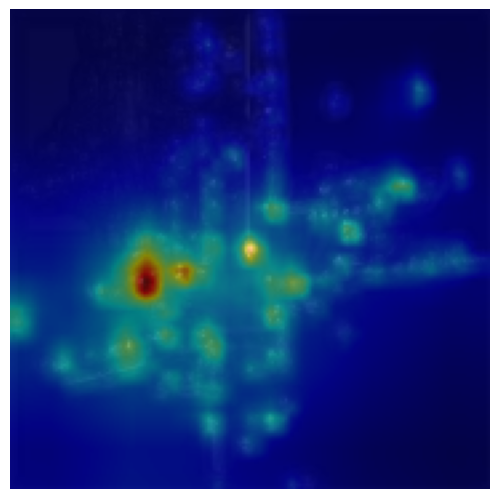

In [163]:
names  = ['late', 'mid', 'early', 'CONC','INJ']
for i, cam in enumerate(cams):
    # if i != 4:
    #     continue
    cam = cams[i]
    input_tensor = inputs[i]
    print(input_tensor.shape)
    img = input_tensor[0].detach().cpu().numpy()
    img = np.max(img, axis=0)
    img = img/np.max(img)
    img = img[:,:,np.newaxis]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    model_outputs = cam.outputs
    #Softmax the outputs, and get label
    model_outputs = F.softmax(model_outputs, dim=1)
    model_outputs = model_outputs.detach().cpu().numpy()
    argmax = np.argmax(model_outputs)
    print(i,argmax, 0)
    # if i == 4:
    #     grayscale_cam = 1-grayscale_cam
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(f'./outputs/vis_lonly{i}.png', bbox_inches='tight', pad_inches=0)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:07<00:00,  2.18it/s]

(90, 90)


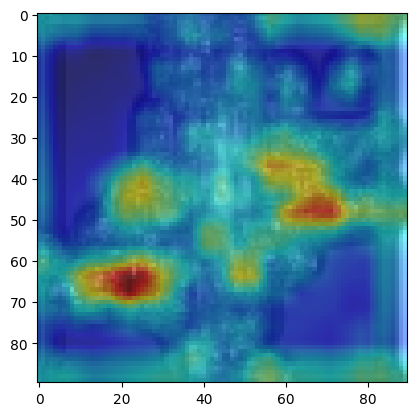

In [164]:

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=act_sample[0][-1].unsqueeze(0), targets=targets)
channel_wise_max_r = act_sample[0][-1].detach().cpu().numpy().max(axis=0)[:,:,np.newaxis]
channel_wise_max_r /= channel_wise_max_r.max()
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
print(grayscale_cam.shape)
img = img.astype(np.float32)/255
visualization = show_cam_on_image(channel_wise_max_r, grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
model_outputs = cam.outputs
#Plot visualization
from matplotlib import pyplot as plt
plt.imshow(visualization)

In [165]:
ckpts_dir = './outputs/ckpts'
existing_ckpts = glob(os.path.join(ckpts_dir, '*.pth'))
len(existing_ckpts)

117

In [166]:
existing_pts = glob(os.path.join(ckpts_dir, '*.pt'))
print(existing_pts)

['./outputs/ckpts/point_pillar_kitti_activations.pt']


In [167]:
centerpoint_ckpts = list(filter(lambda x: 'centerpoint' in x or 'nus' in x, existing_ckpts))
len(centerpoint_ckpts)

117

In [168]:
only_files = [os.path.basename(x) for x in centerpoint_ckpts]
from pprint import pprint
pprint(only_files)

['nuscenes_none_resnet18_fcn_multilogical-mountain-420_Ep1.pth',
 'nuscenes_none_resnet18_fcn2_rawstellar-feather-330_Ep0.pth',
 'nuscenes_none_resnet18_fcn_wor_rawlikely-mountain-670_Ep7.pth',
 'nuscenes_none_resnet18_fcn_wor_multidummy-qrtfhebd0__best.pth',
 'nuscenes_none_resnet18_fcn_rawneat-bush-440__best.pth',
 'nuscenes_none_resnet18_fcn2_wor_rawbalmy-dew-570_Ep0.pth',
 'nuscenes_none_resnet18_fcn2_rawnus_centerpoint_filtered_wobjf mid0_Ep6.pth',
 'nuscenes_none_resnet18_fcn_rawproud-hill-430_Ep1.pth',
 'nuscenes_none_resnet18_fcn_wor_rawrosy-microwave-610__best.pth',
 'nuscenes_none_resnet18_fcn2_rawstellar-feather-330_Ep4.pth',
 'nuscenes_none_resnet18_fcn2_rawstellar-feather-330_Ep2.pth',
 'nuscenes_none_resnet18_fcn2_rawlight-silence-470__best.pth',
 'nuscenes_none_resnet18_fcn_multilogical-mountain-420_Ep3.pth',
 'nuscenes_none_resnet18_fcn_mult_c_efmdauntless-night-390_Ep6.pth',
 'nuscenes_none_resnet18_fcn_rawjolly-terrain-490_Ep0.pth',
 'nuscenes_none_resnet18_fcn_wor_mu

In [169]:
best_ckpts = list(filter(lambda x: 'best' in x, centerpoint_ckpts))
pprint(best_ckpts)

['./outputs/ckpts/nuscenes_none_resnet18_fcn_wor_multidummy-qrtfhebd0__best.pth',
 './outputs/ckpts/nuscenes_none_resnet18_fcn_rawneat-bush-440__best.pth',
 './outputs/ckpts/nuscenes_none_resnet18_fcn_wor_rawrosy-microwave-610__best.pth',
 './outputs/ckpts/nuscenes_none_resnet18_fcn2_rawlight-silence-470__best.pth',
 './outputs/ckpts/nuscenes_none_resnet18_fcn_two_layer_rawwandering-salad-510__best.pth',
 './outputs/ckpts/nuscenes_none_resnet18_fcn_mult_c_efmnus_centerpoint_filtered_wobjf '
 'concat0__best.pth',
 './outputs/ckpts/nuscenes_none_resnet18_fcn2_rawdriven-tree-450__best.pth',
 './outputs/ckpts/nuscenes_none_resnet18_fcn2_rawstellar-feather-330__best.pth',
 './outputs/ckpts/nuscenes_none_resnet18_fcn_rawsweet-river-480__best.pth',
 './outputs/ckpts/nuscenes_none_resnet18_fcn_rawglorious-night-460__best.pth',
 './outputs/ckpts/nuscenes_none_resnet18_fcn_wor_multiupbeat-elevator-810__best.pth',
 './outputs/ckpts/nuscenes_none_resnet18_fcn_rawnus_centerpoint_filtered_wobjf '
 '

In [170]:
import pandas as pd
df_pt = pd.DataFrame(columns=['ckpt', 'input_shape'])
centerpoint_pts = list(filter(lambda x: 'centerpoint' in x, existing_pts))
print(len(centerpoint_pts))
for ckpt in centerpoint_pts:
        state_dict = torch.load(ckpt)
        for key, value in state_dict.items():
                names= ckpt.split('/')[-1]
                temp = pd.DataFrame([[names, value.shape]], columns=['ckpt', 'input_shape'])
                df_pt = pd.concat([df_pt, temp], ignore_index=True)
                break
df_pt

0


,ckpt,input_shape


In [171]:
import pandas as pd
df = pd.DataFrame(columns=['ckpt', 'input_shape'])
for ckpt in centerpoint_ckpts:
        state_dict = torch.load(ckpt)
        for key, value in state_dict.items():
                names= ckpt.split('/')[-1]
                temp = pd.DataFrame([[names, value.shape]], columns=['ckpt', 'input_shape'])
                df_pt = pd.concat([df_pt, temp], ignore_index=True)
                break
df.head()

,ckpt,input_shape


In [172]:
df.to_csv('centerpoint_ckpts.csv', index=False)

In [173]:
from datasets.activation_dataset import ActivationDataset
import numpy as np
from modules import *
from utils.utils import generate_model_from_config
import torch
import torch.nn as nn
from modules.custom_networks import GenericInjection
import pandas as pd
from utils.process import *
config = {
      'root_dir': '/mnt/ssd2/custom_dataset/vehicle_centerpoint_activations_aggregated_raw/',
      'label_file': 'vehicle_centerpoint_labels_aggregated_raw_filtered.csv',
      'classes': ['No Error', 'Error'],
      'label_field': 'is_missed',
      'layer': [0,1,2], #1 , #
      'is_multi_feature':True,#  False,#
      'name': 'custom'}
# config={
#       'root_dir': '/mnt/ssd2/custom_dataset/nus_centerpoint_activations_filtered_all/',
#       'label_file': 'nus_centerpoint_labels_filtered_all.csv',
#       'classes': ['No Error', 'Error'],
#       'label_field': 'is_missed',
#       'layer': 0,
#       'is_multi_feature': False,
#       'name': 'nuscenes'
#       }
# preds = pd.DataFrame(columns=['filename','pred','label'])

processor = MultiFeatureActivationEarlyFused({})

model_config = {'layer_config': 'configs/networks/resnet18_fcn.yaml'}#
# model_config = {'layer_config': 'configs/networks/resnet18_fcn_mult_c.yaml'}#
# model_load_from = "/home/yatbaz_h@WMGDS.WMG.WARWICK.AC.UK/nuscenes_filtered_early_best.pth"
ckpts_dir = './outputs/ckpts'
model_load_from = os.path.join(ckpts_dir, 'nuscenes_none_resnet18_fcn_vis_multi0.pth')
model = generate_model_from_config(model_config)
model = GenericInjection(model_config)
# model.load_state_dict(torch.load(model_load_from))
dataset = ActivationDataset(config)
model.to('cuda:0')
preds = pd.DataFrame(columns=['filename','pred','label'])

from tqdm.auto import tqdm
with tqdm(total=len(dataset)) as pbar:
    for i,data in enumerate(dataset):
        tensor,label, meta = data

        # tensor = tensor.to('cuda:0').unsqueeze(0)
        tensor = [t.unsqueeze(0).to('cuda:0') for t in tensor]
        # tensor = processor.process(activation = tensor, stack =True)
        res = model(tensor)
        #softmaxed:
        res = nn.functional.softmax(res, dim=1)
        pred = torch.argmax(res)
        # preds.append({'pred':pred.item(),'label':label.item()})
        pbar.update(1)
        temp_df = pd.DataFrame({'filename':meta,'pred':pred.item(),'label':label.item()},index=[0])
        preds = pd.concat([preds,temp_df])

# print

Loading model yaml
/media/wmg-5gcat/Co-op Autonomy 2/Hakan/Introspect3D/configs/networks/resnet18_fcn.yaml
Model yaml loaded
Loading model yaml
/media/wmg-5gcat/Co-op Autonomy 2/Hakan/Introspect3D/configs/networks/resnet18_fcn.yaml
Model yaml loaded
ROOT DIR:  /mnt/ssd2/custom_dataset/vehicle_centerpoint_activations_aggregated_raw/
Number of features found:  0  in  []
Threshold is  None


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ssd2/custom_dataset/vehicle_centerpoint_activations_aggregated_raw/vehicle_centerpoint_labels_aggregated_raw_filtered.csv'

In [ ]:
preds.head()

,filename,pred,label
0,20240430_100159,1,1
0,20240430_100201,1,0
0,20240430_100203,0,0
0,20240430_100205,1,0
0,20240430_100207,1,0


In [ ]:
preds.to_csv('inj_no_finetune_preds.csv',index=False)

In [ ]:
preds.head()

,filename,pred,label
0,20240430_100159,1,1
0,20240430_100201,1,0
0,20240430_100203,0,0
0,20240430_100205,1,0
0,20240430_100207,1,0


In [ ]:
# pred_df = pd.DataFrame(preds)
from sklearn.metrics import classification_report
print(classification_report(preds.label.values.astype(int),preds.pred.values.astype(int)))


              precision    recall  f1-score   support

           0       0.66      0.40      0.49       622
           1       0.33      0.59      0.42       315

    accuracy                           0.46       937
   macro avg       0.49      0.49      0.46       937
weighted avg       0.55      0.46      0.47       937



In [ ]:
from torchmetrics import AUROC

ROC = AUROC(num_classes=2,task='binary')
ROC(torch.from_numpy(preds.label.values.astype(int)),torch.from_numpy(preds.pred.values.astype(int)))


tensor(0.4942)